In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from scipy.signal import butter, filtfilt

# UCI-HAR 자이로스코프 데이터 로드
def load_ucihar_gyro_data():
    gyro_x_train_path = './원본 데이터/UCI HAR Dataset/train/Inertial Signals/body_gyro_x_train.txt'
    gyro_y_train_path = './원본 데이터/UCI HAR Dataset/train/Inertial Signals/body_gyro_y_train.txt'
    gyro_z_train_path = './원본 데이터/UCI HAR Dataset/train/Inertial Signals/body_gyro_z_train.txt'
    
    # 데이터 로드
    gyro_x_train = pd.read_csv(gyro_x_train_path, delim_whitespace=True, header=None).values
    gyro_y_train = pd.read_csv(gyro_y_train_path, delim_whitespace=True, header=None).values
    gyro_z_train = pd.read_csv(gyro_z_train_path, delim_whitespace=True, header=None).values

    # 자이로 데이터를 결합하여 하나의 입력 데이터로 만듭니다.
    X_train = np.stack((gyro_x_train, gyro_y_train, gyro_z_train), axis=2)
    
    return X_train

X_train_ucihar = load_ucihar_gyro_data()

# 데이터 정규화
scaler = StandardScaler()
X_train_ucihar = scaler.fit_transform(X_train_ucihar.reshape(-1, X_train_ucihar.shape[-1])).reshape(X_train_ucihar.shape)

# UCI-HAR 데이터를 8:2로 나누기
X_train, X_val = train_test_split(X_train_ucihar, test_size=0.2, random_state=42)

# 텐서로 변환 및 DataLoader 생성
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val), batch_size=64, shuffle=False)

# 자이로 데이터.csv 로드 및 전처리
gyro_data = pd.read_csv('./원본 데이터/자이로 데이터.csv')
gyro_data_values = gyro_data[['X', 'Y', 'Z']].values

# 자이로 데이터 정규화
gyro_data_scaled = scaler.transform(gyro_data_values)

# 텐서로 변환
gyro_data_scaled = torch.tensor(gyro_data_scaled, dtype=torch.float32)


C:\Users\user\AppData\Local\Temp\ipykernel_9752\707106814.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  gyro_x_train = pd.read_csv(gyro_x_train_path, delim_whitespace=True, header=None).values
C:\Users\user\AppData\Local\Temp\ipykernel_9752\707106814.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  gyro_y_train = pd.read_csv(gyro_y_train_path, delim_whitespace=True, header=None).values
C:\Users\user\AppData\Local\Temp\ipykernel_9752\707106814.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  gyro_z_train = pd.read_csv(gyro_z_train_path, delim_whitespace=True, header=None).values


C:\Users\user\anaconda3\envs\ai\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52629 (\N{HANGUL SYLLABLE CUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\anaconda3\envs\ai\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\anaconda3\envs\ai\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\anaconda3\envs\ai\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


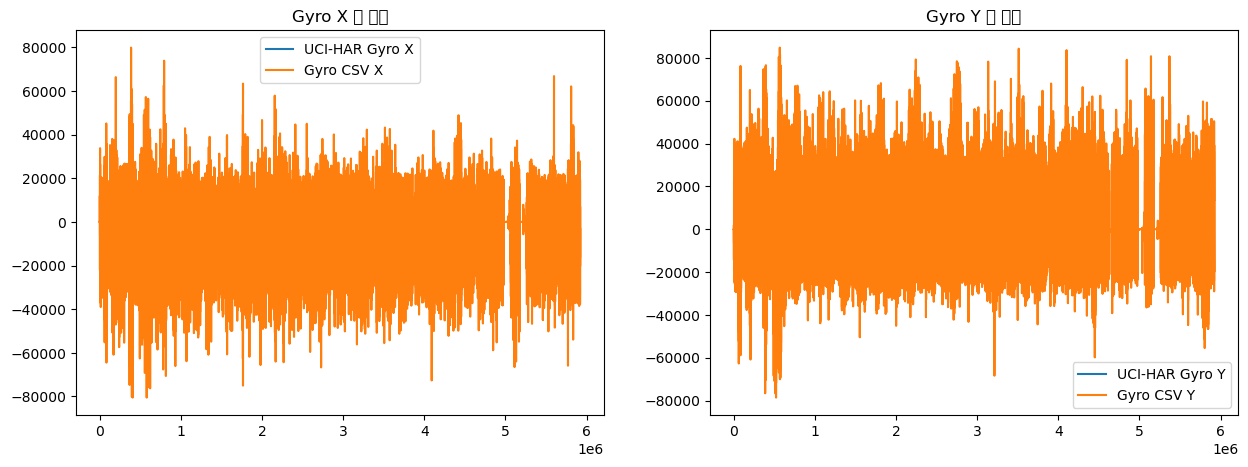

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# 자이로 데이터 비교를 위한 차이 분석
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=X_train_ucihar[:, :, 0].reshape(-1), label='UCI-HAR Gyro X')
sns.lineplot(data=gyro_data_scaled[:, 0].cpu(), label='Gyro CSV X')
plt.title('Gyro X 축 비교')

plt.subplot(1, 2, 2)
sns.lineplot(data=X_train_ucihar[:, :, 1].reshape(-1), label='UCI-HAR Gyro Y')
sns.lineplot(data=gyro_data_scaled[:, 1].cpu(), label='Gyro CSV Y')
plt.title('Gyro Y 축 비교')

plt.show()


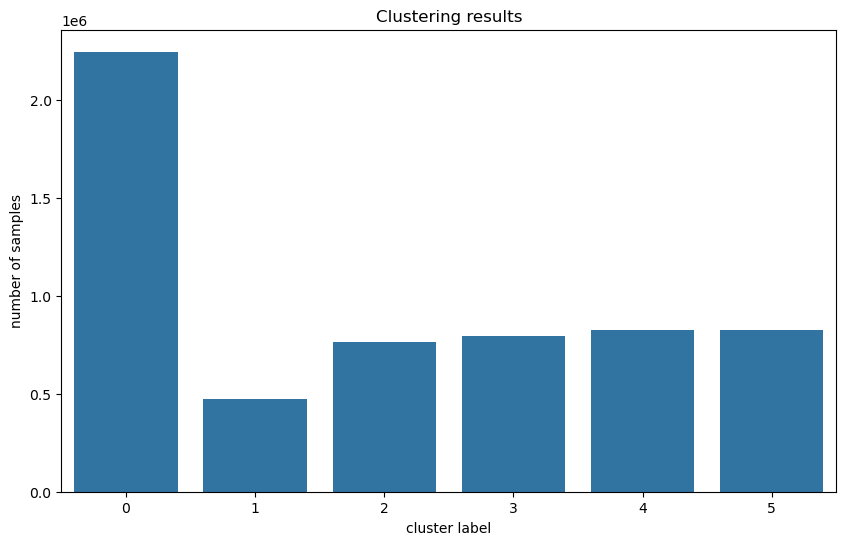

In [3]:
from sklearn.cluster import KMeans

# KMeans 클러스터링 적용
n_clusters = 6  # 예상되는 행동의 수
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(gyro_data_scaled.cpu().numpy())

# 예측된 클러스터 라벨을 추가
gyro_data['Predicted_Cluster'] = kmeans.labels_

# 클러스터 결과 시각화
plt.figure(figsize=(10, 6))
sns.countplot(x='Predicted_Cluster', data=gyro_data)
plt.title('Clustering results')
plt.xlabel('cluster label')
plt.ylabel('number of samples')
plt.show()

In [ ]:
# 저역 통과 필터 적용
def butter_lowpass_filter(data, cutoff=0.1, fs=1.0, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data, axis=0)
    return y

# 자이로 데이터 필터링
gyro_data_filtered = butter_lowpass_filter(gyro_data_scaled.cpu().numpy())

# 필터링 결과 시각화
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(gyro_data_scaled[:, 0].cpu(), label='Original Gyro X')
plt.plot(gyro_data_filtered[:, 0], label='Filtered Gyro X')
plt.title('Gyro X-Axis Filtering Comparison')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(gyro_data_scaled[:, 1].cpu(), label='Original Gyro Y')
plt.plot(gyro_data_filtered[:, 1], label='Filtered Gyro Y')
plt.title('Gyro Y-Axis Filtering Comparison')
plt.legend()

plt.show()

C:\Users\user\anaconda3\envs\ai\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
